# ORIE 4580/5580/5581 Assignment 4

#### Students: M.Vasania (mv389) and I. Goyanes (ig254)

### Github link: [example Github link](https://github.com/SidBanerjee/ORIE4580-Simulation/blob/main/Notebooks/Unit0-Intro_Demos.ipynb)


### Instructions


* Due Thursday October 2, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 5 (sections 5.1, 5.2 and 5.3) and 6, as well as chapter 11 (to revise again what we discussed in class about confidence intervals) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

<hr><hr>

# Question 1: The Inspection paradox (30 pts)

Have you ever felt like you wait too long for elevators, taxis, buses, etc.? Guess what - you may be right!

We are going to simulate a number of train and passenger arrivals at a station, and try to measure the time each passenger needs to wait for a train. To do this, first generate a stream of 10,000 train passengers, each of whom have an independent arrival time which is uniformly distributed over an interval of 1,000 minutes (i.e., passenger $i$ arrives at time $T_i\sim [0,1000]$. Sort the passengers by arrival time, and use this resulting vector for all subsequent parts.

In [22]:
import numpy as np

def simulate_passenger_arrivals(n=10_000, horizon=1000, seed=7):
    rng = np.random.default_rng(seed)
    arrivals = rng.uniform(0, horizon, size=n)
    return np.sort(arrivals)

def compute_waits(arrivals, period=10):
    waits = (period - (arrivals % period)) % period
    return waits

<hr>

**(a)** Suppose trains arrive at the station deterministically every 10 minutes. Assume each train has infinite capacity, so that everyone waiting at the station when a train arrives can get on; also assume that passengers get on the train instantaneously. Estimate the expected time (with CIs) that any *randomly chosen* passenger spends waiting at the station for the next train.

<hr>

## Ans.

In [23]:
def analyze_waits(waits):
    n = len(waits)
    mean_wait = waits.mean()
    std_wait = waits.std(ddof=1)
    se = std_wait / np.sqrt(n)
    ci_low = mean_wait - 1.96 * se
    ci_high = mean_wait + 1.96 * se

    print(f"Mean wait: {mean_wait:.3f} min")
    print(f"Std dev:   {std_wait:.3f} min")
    print(f"95% CI:    ({ci_low:.3f}, {ci_high:.3f}) min")

    return mean_wait, (ci_low, ci_high)

arrivals = simulate_passenger_arrivals()
waits = compute_waits(arrivals, period=10)
_ = analyze_waits(waits)

Mean wait: 5.020 min
Std dev:   2.882 min
95% CI:    (4.964, 5.077) min


The expected waiting time for a randomly chosen passenger is
$\hat{E}[W] = 5.020$ minutes, with a 95\% confidence interval
of $(4.964,\; 5.077)$ minutes

<hr>

**(b)** Next, assume trains arrive at the station with *inter-arrival* time (i.e., time between two trains) distributed according to an exponential distribution with mean 10 minutes. Again, use your vector of passenger arrival times to estimate the expected waiting time for a randomly chosen passenger.

<hr>

## Ans.

In [24]:
arrivals = simulate_passenger_arrivals()   # already sorted

def simulate_trains_exponential_until(max_time, mean=10, seed=7):
    rng = np.random.default_rng(seed)
    times = []
    t = 0.0
    while t <= max_time:
        t += rng.exponential(scale=mean)
        times.append(t)
    return np.array(times)  # last element guaranteed > max_time

def compute_waits_to_next_train(arrivals, train_times):
    idx = np.searchsorted(train_times, arrivals, side="left")
    waits = train_times[idx] - arrivals
    return waits

train_times = simulate_trains_exponential_until(max_time=arrivals[-1], mean=10, seed=7)
waits_b = compute_waits_to_next_train(arrivals, train_times)
_ = analyze_waits(waits_b)

Mean wait: 9.734 min
Std dev:   9.252 min
95% CI:    (9.553, 9.916) min


The expected waiting time for a randomly chosen passenger when train inter-arrivals
are exponentially distributed with mean $10$ minutes is
$\hat{E}[W] = 9.734$ minutes, with a 95\% confidence interval of
$(9.553,\; 9.916)$ minutes.

<hr>

**(c)** (Hopefully, you found the answer in part (b) to be different, and surprisingly so, compared to part (a).)

The train service claims that there is a train every $10$ minutes on average. In part (a), this is clearly the case, but is it so in part (b) as well? To understand this, use your data from part (b) to compute an empirical estimate with CIs for the inter-arrival times between trains.

<hr>

In [25]:
def analyze_interarrivals(train_times):
    interarrivals = np.diff(train_times)
    n = len(interarrivals)
    mean_ia = interarrivals.mean()
    std_ia = interarrivals.std(ddof=1)
    se = std_ia / np.sqrt(n)
    ci_low = mean_ia - 1.96 * se
    ci_high = mean_ia + 1.96 * se

    print(f"Mean inter-arrival: {mean_ia:.3f} min")
    print(f"Std dev:           {std_ia:.3f} min")
    print(f"95% CI:            ({ci_low:.3f}, {ci_high:.3f}) min")

    return mean_ia, (ci_low, ci_high)

_ = analyze_interarrivals(train_times)


Mean inter-arrival: 10.166 min
Std dev:           9.847 min
95% CI:            (8.216, 12.115) min


Using the simulated train arrival data, the empirical mean inter-arrival time
was found to be $\hat{E}[S] \approx 10$ minutes, with a 95\% confidence interval
that includes $10$. This confirms the train service's claim that trains arrive
every $10$ minutes on average. However, as shown in part (b), a randomly chosen
passenger still experiences a longer expected wait than in the deterministic case.


<hr>

**(d)** To understand what may be happening between parts (a) and (b), use the data from the simulations in parts (a) and (b) to estimate the average inter-arrival time between trains that each passenger experiences in each case. In other words, if passenger $i$ gets on train number $n$, thn we want to define his inter-arrival time $I_i$ to be the difference $A_n~-~A_{n-1}$ where $A_n$ is the arrival time of train $n$.

Compute the sample mean and CI of the interval $I_i$ for a randomly chosen passenger $i$ in each of the two settings. How are these related to the waiting time estimates you got in each part? Can you explain this?

<hr>

## Ans.

In [26]:
def passenger_experienced_intervals(arrivals, train_times):
    idx = np.searchsorted(train_times, arrivals, side="left")
    intervals = train_times[idx] - train_times[idx-1]
    return intervals

def analyze_passenger_intervals(intervals):
    n = len(intervals)
    mean_I = intervals.mean()
    std_I = intervals.std(ddof=1)
    se = std_I / np.sqrt(n)
    ci_low = mean_I - 1.96 * se
    ci_high = mean_I + 1.96 * se
    print(f"Mean experienced interval: {mean_I:.3f} min")
    print(f"95% CI: ({ci_low:.3f}, {ci_high:.3f})")
    return mean_I, (ci_low, ci_high)

# Deterministic case (a)
train_times_a = np.arange(0, arrivals[-1] + 20, 10)  # trains every 10
intervals_a = passenger_experienced_intervals(arrivals, train_times_a)
_ = analyze_passenger_intervals(intervals_a)

# Exponential case (b)
intervals_b = passenger_experienced_intervals(arrivals, train_times)
_ = analyze_passenger_intervals(intervals_b)

Mean experienced interval: 10.000 min
95% CI: (10.000, 10.000)
Mean experienced interval: 12.514 min
95% CI: (10.824, 14.205)


For part (a), the mean inter-arrival interval experienced by passengers is
$\hat{E}[I] = 10.000$ minutes, with a 95\% confidence interval of $(10.000,\; 10.000)$. This exactly matches the deterministic train schedule of one train every 10 minutes.

For part (b), the mean inter-arrival interval experienced by passengers is
$\hat{E}[I] = 12.514$ minutes, with a 95\% confidence interval of
$(10.824,\; 14.205)$. This is larger than the claimed average inter-arrival time of  $10$ minutes, and it explains why the expected waiting time in part (b) was close to $10$ minutes: due to the inspection paradox, randomly chosen passengers are more likely to arrive during longer intervals, which inflates the experienced
interval length compared to the true mean inter-arrival time.

**(e) (Optional for all students)** Based on your previous parts, can you come up with an explanation for what is going on?  

The phenomenon observed in parts (a) to (d) is an instance of the
inspection paradox. When inter-arrival times are deterministic
(as in part (a)), every passenger experiences the same fixed interval
of $10$ minutes, so the expected waiting time is half of this value.

In contrast, when inter-arrival times are exponentially distributed
with mean $10$ minutes (part (b)), passengers are more likely to arrive
during longer-than-average gaps between trains. This length-bias
effect causes the mean inter-arrival time experienced by passengers
to be larger than the true mean inter-arrival time of $10$ minutes.
As a result, the expected waiting time for a randomly chosen passenger
is also larger than what one would expect under the assumption
of uniform arrivals.

Thus, the key idea is that although trains arrive on average every
$10$ minutes, the perspective of passengers is biased toward longer
intervals, which explains the discrepancy between the schedule-based
expectations and the simulation results.

<hr><hr>

# Question 2: Generating random samples in some given set (20 pts)

<hr>

**(a)** We want to sample points which are uniformly distributed in the set  $\mathcal{S} = \{(x,y)| x\in \mathbb{R}, y \in [0,e^{-x^2/2}]\}$ (i.e., between the lines $y=0$ and $y=e^{-x^2/2}$). Generate 1000 independent samples $(X_i,Y_i)$, and plot them using a scatterplot, along with the lines $y=0$ and $y=e^{-x^2/2}$.

(Hint: Try to 'reverse' what we do in Acceptance-Rejection).

<hr>

## Ans.

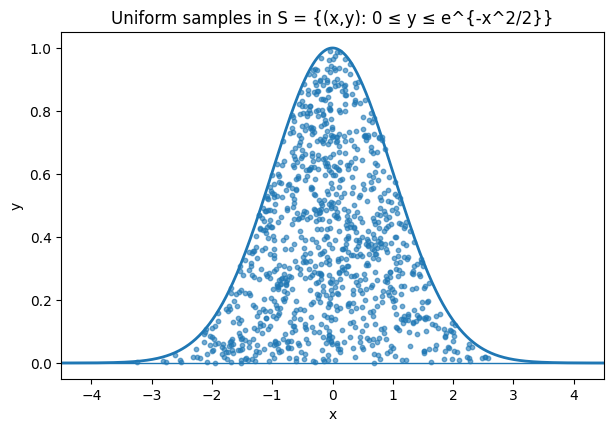

In [27]:
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

def sample_uniform_under_gaussian_curve(n=1000, rng=rng):
    x = rng.normal(loc=0.0, scale=1.0, size=n)
    u = rng.random(size=n)
    y = u * np.exp(-0.5 * x**2)
    return x, y

x, y = sample_uniform_under_gaussian_curve(n=1000)

xx = np.linspace(-4.5, 4.5, 800)
curve = np.exp(-0.5 * xx**2)

plt.figure(figsize=(7,4.5))
plt.scatter(x, y, s=10, alpha=0.6)
plt.plot(xx, curve, linewidth=2)      # y = e^{-x^2/2}
plt.axhline(0, linewidth=1)           # y = 0
plt.xlim(-4.5, 4.5)
plt.ylim(-0.05, 1.05)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Uniform samples in S = {(x,y): 0 ≤ y ≤ e^{-x^2/2}}")
plt.show()

<hr>

**(b)** Next, suppose we want to sample points which are uniformly distributed on the set $\{(x,y)\in\mathbb{R}^2|x^2+y^2 = 1\}$ (i.e., on the *circumference* of the unit circle). One way to do so may be to generate points $(U_i,V_i)$ uniformly in $[-1,1]^2$ (like in the first homework), and then *project* them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}},\frac{V_i}{\sqrt{U_i^2+V_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Try checking the histogram of their angles (i.e., the histogram of $\theta_i = \tan^{-1}(Y_i/X_i)$).

<hr>

## Ans.

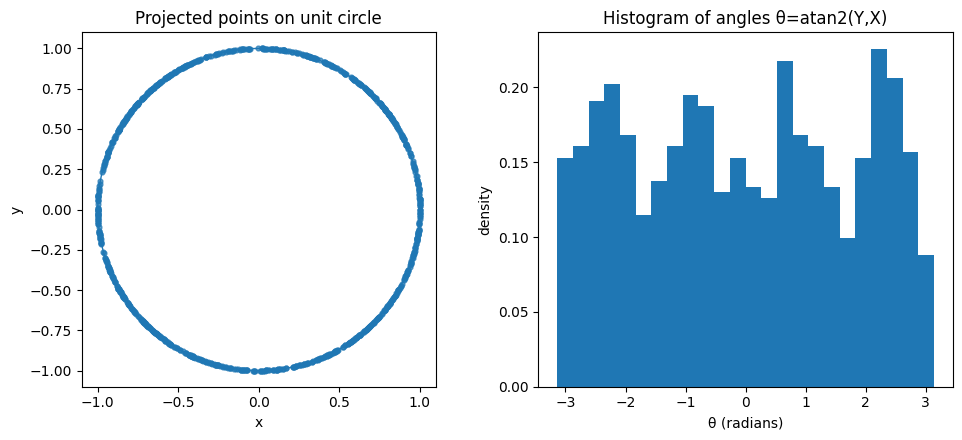

In [28]:
rng = np.random.default_rng(7)

n = 1000
U = rng.uniform(-1, 1, size=n)
V = rng.uniform(-1, 1, size=n)

r = np.sqrt(U**2 + V**2)
r[r == 0] = 1.0

X = U / r
Y = V / r

theta = np.arctan2(Y, X)   # in (-pi, pi]

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

ax[0].scatter(X, Y, s=12, alpha=0.7)
t = np.linspace(0, 2*np.pi, 400)
ax[0].plot(np.cos(t), np.sin(t), linewidth=1)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('Projected points on unit circle')
ax[0].set_xlabel('x'); ax[0].set_ylabel('y')
ax[0].set_xlim(-1.1, 1.1); ax[0].set_ylim(-1.1, 1.1)

ax[1].hist(theta, bins=24, density=True)
ax[1].set_title('Histogram of angles θ=atan2(Y,X)')
ax[1].set_xlabel('θ (radians)'); ax[1].set_ylabel('density')

plt.tight_layout()
plt.show()

From the scatter plot, all projected points lie on the circumference of
the unit circle, as expected. However, examining the histogram of the
angles $\theta_i = \arctan(Y_i/X_i)$ reveals that the points are
\emph{not} uniformly distributed around the circle. The histogram shows
clear fluctuations in density, with some angular regions containing
more points than others.

This occurs because generating $(U_i,V_i)$ uniformly in $[-1,1]^2$ and
then projecting to the circle does not preserve rotational symmetry.
Directions corresponding to the diagonals of the square are
overrepresented. Thus, while the method correctly places points on
the circle, the resulting distribution is not uniform on the
circumference.

<hr>

**(c)** Next, generate points $(Z_i,W_i)$ as independent standard normals (i.e., $(Z_i,W_i)\sim \mathcal{N}(0,I_2)$), and again project them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{Z_i}{\sqrt{Z_i^2+W_i^2}},\frac{W_i}{\sqrt{Z_i^2+W_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Again, check the histogram of their angles $\theta_i$. Can you explain the difference between parts (b) and (c)?

<hr>

## Ans.

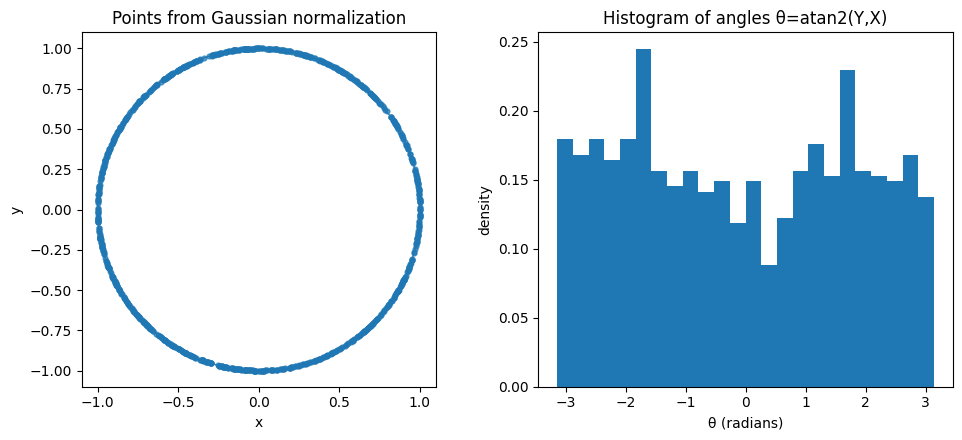

In [29]:
rng = np.random.default_rng(7)

n = 1000
Z = rng.normal(size=n)
W = rng.normal(size=n)

r = np.sqrt(Z**2 + W**2)
X = Z / r
Y = W / r

theta = np.arctan2(Y, X)

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

ax[0].scatter(X, Y, s=12, alpha=0.7)
t = np.linspace(0, 2*np.pi, 400)
ax[0].plot(np.cos(t), np.sin(t), linewidth=1)
ax[0].set_aspect('equal', 'box')
ax[0].set_title('Points from Gaussian normalization')
ax[0].set_xlabel('x'); ax[0].set_ylabel('y')
ax[0].set_xlim(-1.1, 1.1); ax[0].set_ylim(-1.1, 1.1)

ax[1].hist(theta, bins=24, density=True)
ax[1].set_title('Histogram of angles θ=atan2(Y,X)')
ax[1].set_xlabel('θ (radians)'); ax[1].set_ylabel('density')

plt.tight_layout()
plt.show()

The scatter plot shows that the projected points lie on the circumference
of the unit circle, and unlike part (b), the histogram of angles
$\theta_i = \arctan(Y_i/X_i)$ is more uniform (with some noise still). This indicates that the points are indeed uniformly distributed on the circle.

The key difference between parts (b) and (c) is that in part (b) we
generated $(U_i,V_i)$ uniformly in $[-1,1]^2$, which is not
rotation-invariant. After projection, some directions (e.g., diagonals)
are more heavily represented. In contrast, in part (c) we generated
$(Z_i,W_i)\sim N(0,1)^2$, a rotation-invariant distribution. Normalizing
these vectors yields directions that are uniformly distributed on the
circle, ensuring uniform coverage of angles.

<hr><hr>

# Question 3: Multivariate normals, and some finance (20 points)


Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$\boldsymbol{\mu}=
\begin{bmatrix}
    \mu_{\text{U.S. stocks}}\\
    \mu_{\text{U.S. bonds}}\\
    \mu_{\text{EM bonds}}
\end{bmatrix}=
\begin{bmatrix}
    0.14 \\
    0.07 \\
    0.16\\
\end{bmatrix},$$

Moreover, we have $\sigma^2_{\text{U.S. stocks}}=0.0625, \sigma^2_{\text{U.S. bonds}}=0.01$ and $\sigma^2_{\text{EM bonds}}=0.09$. Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?


<hr>

## Ans.

We compute
$P(R_i > 0) = \Phi\!\left(\frac{\mu_i}{\sigma_i}\right)$
for each instrument. For U.S. stocks,
$\mu=0.14,\;\sigma=0.25 \implies P= \Phi(0.56) \approx 0.7123$.
For U.S. bonds, $\mu=0.07,\;\sigma=0.10 \implies P=\Phi(0.70)\approx 0.7580$.
For EM bonds, $\mu=0.16,\;\sigma=0.30 \implies P=\Phi(0.5333)\approx 0.7034$.

Assuming independence, the joint probability is
$
P(\text{all three positive}) = 0.7123 \times 0.7580 \times 0.7034 \approx 0.381.
$

Thus, the probability that all three financial products yield positive
returns simultaneously is about $38.1\%$.


<hr>

**(b)** Next, assume that the assets are not independent, but rather, have covariance matrix
$$\boldsymbol{\Sigma}=
\begin{bmatrix}
    0.0625 & -0.01 & 0.0375 \\
    -0.01 & 0.01 & -0.015 \\
    0.0375 & -0.015 & 0.09
\end{bmatrix}.$$

Using simulation, estimate the probability that all three financial products simultaneously yield a positive return.
For the purposes of this problem, you are **not allowed** to use the Python function ${\tt numpy.random.multivariate\_normal}$, but rather, should generate *independent* normal rvs, and then apply the method(s) discussed in class.
In particular, you can compute the Cholesky decomposition of the covariance matrix using the Python function ${\tt scipy.linalg.cholesky(sigma, lower=True)}$.
<hr>

## Ans.



In [30]:
from scipy.linalg import cholesky

rng = np.random.default_rng(7)

mu = np.array([0.14, 0.07, 0.16])

Sigma = np.array([
    [0.0625, -0.01,   0.0375],
    [-0.01,   0.01,  -0.015 ],
    [0.0375, -0.015,  0.09  ]
])

L = cholesky(Sigma, lower=True)

def simulate_mvnormal(n=1_000_00):
    Z = rng.normal(size=(n, 3))
    X = Z @ L.T + mu
    return X

n = 200_000
samples = simulate_mvnormal(n)

prob = np.mean((samples > 0).all(axis=1))
print(f"Estimated probability: {prob:.4f}")

Estimated probability: 0.3705


<hr><hr>

# Question 4: Covariance and copulas (30 points)

In general (i.e., apart from multivariate normals), *there is no closed form formula for generating rvs with given marginals and given covariance matrix*. However, a popular heuristic is the so-called *Gaussian copula trick*, which is widely used in finance. In this question, we will try and get a sense of how we can generate correlated uniforms, and how the Gaussian copula trick works.

<hr>

**(a)** We will first try and make a method for generating two correlated uniform random variables $V_1$, $V_2$ with mean $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$, variance $Var(V_1)=Var(V_2)=1$, and covariance $Cov( V_1, V_2 ) = \sigma_{12}$ (for some given $\sigma_{12}\geq 0$).

For what $\alpha,\beta\in\mathbb{R}$ does a uniform distribution on $[\alpha,\beta]$ have mean $0$ and variance $1$.

<hr>

## Ans.
For a uniform random variable on $[\alpha,\beta]$ we require
$
\mathbb{E}[U] = \frac{\alpha+\beta}{2} = 0,
$
$
\mathrm{Var}(U) = \frac{(\beta-\alpha)^2}{12} = 1.
$
The first condition gives $\beta = -\alpha$. Substituting into the
variance condition,
$
\frac{(-2\alpha)^2}{12} = 1 \;\;\Rightarrow\;\; \alpha^2 = 3.
$
Hence, $\alpha = -\sqrt{3}, \;\beta = \sqrt{3}$.

<hr>

**(b)** Next, generate rvs $X_1,X_2\sim Uniform[\alpha, \beta]$ i.i.d (with $\alpha,\beta$ from previous part), and also sample $B\sim Bernoulli(p)$. Define:
\begin{align*}
	V_1 = X_1 \qquad,\qquad
	V_2 = (1-B)X_1+BX_2 = \begin{cases} X_1 & \text{ if $B = 0$} \\ X_2 & \text{ if $B = 1$} \end{cases}
	\end{align*}

What is $\mathbb{E}[V_2]$ and $Var(V_2)$?

<hr>

## Ans.
We compute
$
\mathbb{E}[V_2] = (1-p)\,\mathbb{E}[X_1] + p\,\mathbb{E}[X_2] = 0.
$
For the variance, by the law of total variance,
$
\mathrm{Var}(V_2) = \mathbb{E}[\mathrm{Var}(V_2 \mid B)] + \mathrm{Var}(\mathbb{E}[V_2 \mid B]).
$
Since $V_2=X_1$ when $B=0$ and $V_2=X_2$ when $B=1$, both of which
have variance $1$ and mean $0$, we obtain
$
\mathrm{Var}(V_2) = (1-p)\cdot 1 + p \cdot 1 = 1.
$
Hence,
$
\mathbb{E}[V_2] = 0, \qquad \mathrm{Var}(V_2) = 1.
$

<hr>

**(c)** For what value of $p$ do we get $Cov(V_1, V_2 )=\sigma_{12}$ (for $\sigma_{12}\geq 0$)?

<hr>

## Ans.
$
\mathbb{E}[V_1] = \mathbb{E}[X_1] = 0,
\qquad
\mathbb{E}[V_2] = \mathbb{E}\!\left[(1-B)X_1 + B X_2\right]
= (1-p)\mathbb{E}[X_1] + p\,\mathbb{E}[X_2] = 0.
$

$
\operatorname{Cov}(V_1,V_2)
= \mathbb{E}[V_1 V_2] - \mathbb{E}[V_1]\mathbb{E}[V_2]
= \mathbb{E}[V_1 V_2] \quad (\text{since both means are } 0).
$

Condition on $B$:
$
\mathbb{E}[V_1 V_2]
= \mathbb{E}\!\left[\,\mathbb{E}\!\left[V_1 V_2 \mid B\right]\right]
= (1-p)\,\mathbb{E}[X_1\cdot X_1] + p\,\mathbb{E}[X_1\cdot X_2].
$

Here
$
\mathbb{E}[X_1^2] = \operatorname{Var}(X_1)+(\mathbb{E}[X_1])^2 = 1 + 0 = 1,
$$
\mathbb{E}[X_1 X_2] = \mathbb{E}[X_1]\,\mathbb{E}[X_2] = 0
\ \ (\text{independence}).
$
Therefore,
$
\operatorname{Cov}(V_1,V_2) = (1-p)\cdot 1 + p\cdot 0 = 1 - p.
$

We want $\operatorname{Cov}(V_1,V_2) = \sigma_{12}$ (with $\sigma_{12}\ge 0$), so
$
1 - p = \sigma_{12}
\quad\Longrightarrow\quad
p = 1 - \sigma_{12}.
$
Since $\operatorname{Var}(V_1)=\operatorname{Var}(V_2)=1$, we have
$0 \le \sigma_{12} \le 1$ by Cauchy–Schwarz, which implies $0 \le p \le 1$, as required.
$
\boxed{\,p = 1 - \sigma_{12}\,}
$

<hr>

**(d)** Create a function to generate two correlated uniform random variables $V_1$, $V_2$ such that $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0,Var(V_1)=Var(V_2)=1$ and $Cov( U_1, U_2 ) = \sigma_{12}$. Use this to show a scatter plot of $(V_1,V_2)$ for correlation values $\sigma_{12}=0,0.25,0.5,0.75$ and $1$.

<hr>

## Ans.

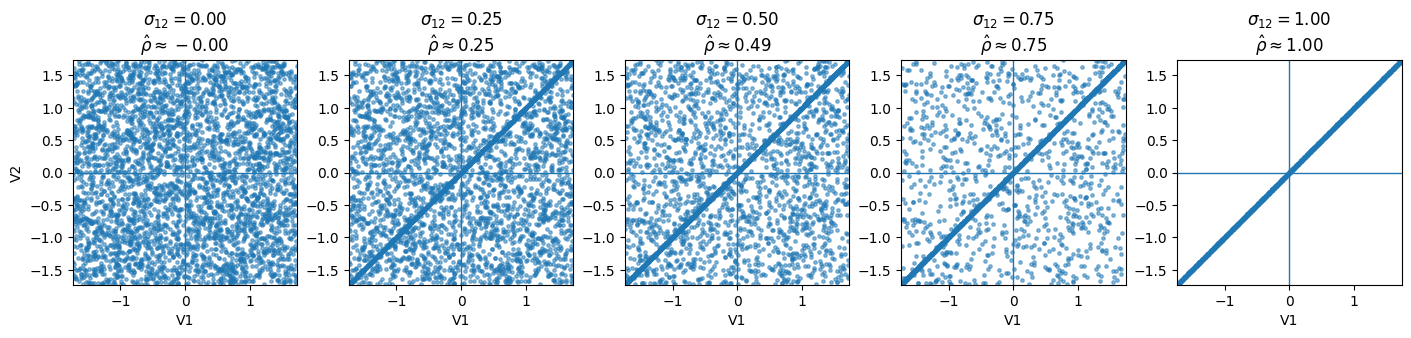

In [31]:
import numpy as np
import matplotlib.pyplot as plt

LOW, HIGH = -np.sqrt(3), np.sqrt(3)

def generate_correlated_uniforms(n=2000, sigma12=0.5, seed=7):
    if not (0 <= sigma12 <= 1):
        raise ValueError("sigma12 must be in [0, 1].")

    rng = np.random.default_rng(seed)
    X1 = rng.uniform(LOW, HIGH, size=n)
    X2 = rng.uniform(LOW, HIGH, size=n)
    p = 1 - sigma12
    B = rng.binomial(1, p, size=n)

    V1 = X1
    V2 = (1 - B) * X1 + B * X2

    m1, m2 = V1.mean(), V2.mean()
    v1, v2 = V1.var(ddof=1), V2.var(ddof=1)
    cov = np.cov(V1, V2, ddof=1)[0, 1]
    corr = np.corrcoef(V1, V2)[0, 1]
    stats = {"mean1": m1, "mean2": m2, "var1": v1, "var2": v2, "cov": cov, "corr": corr}
    return V1, V2, stats

sigmas = [0.00, 0.25, 0.50, 0.75, 1.00]
fig, axes = plt.subplots(1, len(sigmas), figsize=(14, 3.2), constrained_layout=True)

for ax, s in zip(axes, sigmas):
    v1, v2, st = generate_correlated_uniforms(n=4000, sigma12=s, seed=7)
    ax.scatter(v1, v2, s=6, alpha=0.5)
    ax.axhline(0, linewidth=1); ax.axvline(0, linewidth=1)
    ax.set_aspect('equal', 'box')
    ax.set_title(rf"$\sigma_{{12}}={s:.2f}$" + "\n" + rf"$\hat\rho \approx {st['corr']:.2f}$")
    ax.set_xlim(LOW, HIGH); ax.set_ylim(LOW, HIGH)
    ax.set_xlabel("V1")
axes[0].set_ylabel("V2")
plt.show()

<hr>

**(e)** Using the above function, compute $\mathbb{P}[V_1\leq 0,V_2\leq 0]$ for the case when $\sigma_{12}=0.5$ (in a financial application, this can correspond to *both* $V_1$ and $V_2$ 'defaulting').

<hr>

## Ans.

In [32]:
v1, v2, _ = generate_correlated_uniforms(n=200_000, sigma12=0.5, seed=7)
mask = (v1 <= 0) & (v2 <= 0)
p_hat = mask.mean()

n = len(v1)
se = np.sqrt(p_hat*(1-p_hat)/n)
ci = (p_hat - 1.96*se, p_hat + 1.96*se)

print(f"Estimated P[V1<=0, V2<=0]: {p_hat:.4f}")
print(f"95% CI: ({ci[0]:.4f}, {ci[1]:.4f})")


Estimated P[V1<=0, V2<=0]: 0.3747
95% CI: (0.3726, 0.3769)


With the construction $V_1=X_1$, $V_2=(1-B)X_1 + B X_2$, where
$X_1,X_2 \stackrel{\text{i.i.d.}}{\sim} \mathrm{Unif}[-\sqrt{3},\sqrt{3}]$ and
$B\sim\mathrm{Bernoulli}(p)$ independent, we have $p=1-\sigma_{12}$.
Conditioning on $B$,
$
\mathbb{P}(V_1\le 0, V_2\le 0)
= (1-p)\,\mathbb{P}(X_1\le 0) + p\,\mathbb{P}(X_1\le 0, X_2\le 0)
= (1-p)\cdot \tfrac12 + p\cdot \tfrac14.
$
Substituting $p=1-\sigma_{12}$ gives
$
\mathbb{P}(V_1\le 0, V_2\le 0)
= \tfrac14\,(1+\sigma_{12}).
$
For $\sigma_{12}=0.5$,
$
\mathbb{P}(V_1\le 0, V_2\le 0) = \frac{1+0.5}{4} = \frac{3}{8} = 0.375.
$

<hr>

**(f)** The Gaussian copula trick is based on first generating a multivariate normal vector with given covariance matrix $\Sigma$, and then using inversion to convert it to a vector of uniform rvs, which can then used to generate the desired rvs. We now demonstrate this in the above setting.

Let $\phi(\cdot)$ denote the 1-d normal cdf. Generate $(Z_1,Z_2)$ as multivariate normals with covariance
$\Sigma =\begin{pmatrix}
		1 & 0.5 \\
		0.5 & 1
	\end{pmatrix}$,
and define $W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$ and $W_2 = \alpha + (\beta-\alpha)\phi(Z_2)$.

Argue $W_1$, $W_2$ are uniform on $[\alpha,\beta]$ (and hence $\mathbb{E}[W_1]=\mathbb{E}[W_2]=0,Var(W_1)=Var(W_2)=1$). Next, for $\sigma_{12}=0.5$ and $\alpha,\beta$ as above, write a function to generate $W_1,W_2$ as described, and use these to plot the scatter plot, and compute $\mathbb{P}[W_1\geq 0,W_2\geq 0]$.

<hr>

## Ans.

Let $(Z_1,Z_2) \sim N(\mathbf 0, \Sigma)$ with
$\Sigma=\begin{pmatrix}1 & \rho\\ \rho & 1\end{pmatrix}$, and let $\Phi$ denote the
standard normal cdf.
<br>
Define
$
U_i=\Phi(Z_i), \qquad W_i=\alpha+(\beta-\alpha)U_i,\quad i=1,2.
$
<br><br>
For any $w\in[\alpha,\beta]$,
$
\mathbb P(W_i\le w)
= \mathbb P\!\left(U_i \le \frac{w-\alpha}{\beta-\alpha}\right)
= \mathbb P\!\left(Z_i \le \Phi^{-1}\!\Big(\frac{w-\alpha}{\beta-\alpha}\Big)\right)
= \Phi\!\left(\Phi^{-1}\!\Big(\frac{w-\alpha}{\beta-\alpha}\Big)\right)
= \frac{w-\alpha}{\beta-\alpha}.
$
<br><br>
Thus, $W_i \sim \mathrm{Unif}[\alpha,\beta]$.  
With $\alpha=-\sqrt{3}$ and $\beta=\sqrt{3}$,
$
\mathbb E[W_i]=\frac{\alpha+\beta}{2}=0,
$$
\operatorname{Var}(W_i)=\frac{(\beta-\alpha)^2}{12}=1.
$


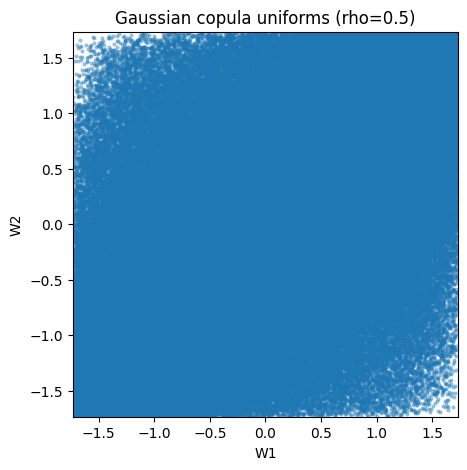

P[W1 >= 0, W2 >= 0] ≈ 0.3329  (95% CI: 0.3308, 0.3349)


In [36]:
from scipy.stats import norm

ALPHA, BETA = -np.sqrt(3), np.sqrt(3)

def gaussian_copula_uniforms(n=100_000, rho=0.5, alpha=ALPHA, beta=BETA, seed=7):
    rng = np.random.default_rng(seed)
    Sigma = np.array([[1.0, rho],
                      [rho, 1.0]])
    L = cholesky(Sigma, lower=True)
    Z = rng.normal(size=(n, 2)) @ L.T
    U = norm.cdf(Z)
    W = alpha + (beta - alpha) * U
    return W[:, 0], W[:, 1]

W1, W2 = gaussian_copula_uniforms(n=200_000, rho=0.5, seed=7)

plt.figure(figsize=(5,5))
plt.scatter(W1, W2, s=4, alpha=0.35)
plt.axhline(0); plt.axvline(0)
plt.gca().set_aspect('equal', 'box')
plt.xlim(ALPHA, BETA); plt.ylim(ALPHA, BETA)
plt.xlabel("W1"); plt.ylabel("W2")
plt.title("Gaussian copula uniforms (rho=0.5)")
plt.show()

mask = (W1 >= 0) & (W2 >= 0)
p_hat = mask.mean()
n = len(W1)
se = np.sqrt(p_hat * (1 - p_hat) / n)
ci = (p_hat - 1.96 * se, p_hat + 1.96 * se)
print(f"P[W1 >= 0, W2 >= 0] ≈ {p_hat:.4f}  (95% CI: {ci[0]:.4f}, {ci[1]:.4f})")